# Imports

In [1]:
import os

In [2]:
%cd ../..

c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica_numpy import fast_ica as fast_ica2
from mva_independent_component_analysis.fast_ica.fastica import fast_ica 


# Generating non-Gaussian sources and mixing them

In [4]:
# Set seed for reproducibility
np.random.seed(0)

# Generate time samples
t = np.linspace(0, 200, 1000)

# Sources
source_1 = np.sin(t*2)
source_2 = 2 * (1.9*t % (2 * np.pi)) / (2 * np.pi) - 1  # Sawtooth wave approximation
source_3 = np.random.random(len(t))

# Stack sources to form S matrix
S = np.array([source_1, source_2, source_3])

# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signals
X = A @ S

# Number of sources, samples, and signals
n_sources, n_samples = S.shape
n_signals = X.shape[0]


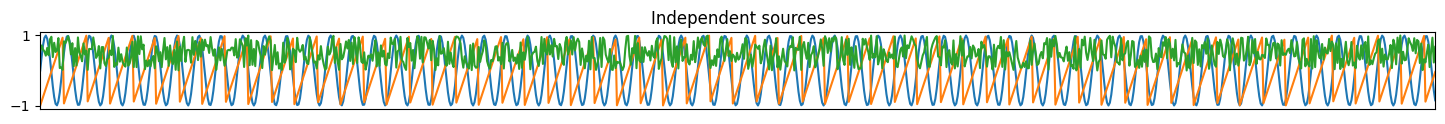

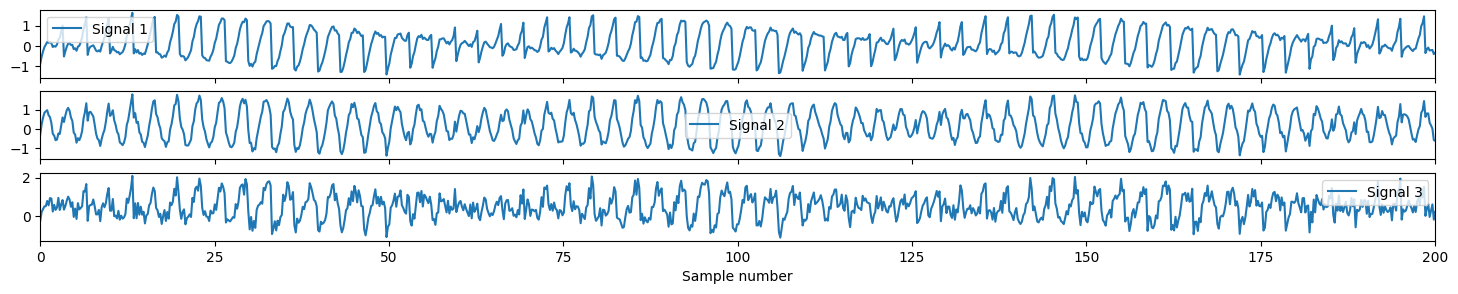

In [5]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 1])
ax.plot(t, S.T)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(t[0], t[-1])
ax.tick_params()
ax.set_title('Independent sources')

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(t, X[signal_number], label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params()
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number')
ax[-1].set_xlim(t[0], t[-1])
plt.show()

### A visual non-Gaussianity test

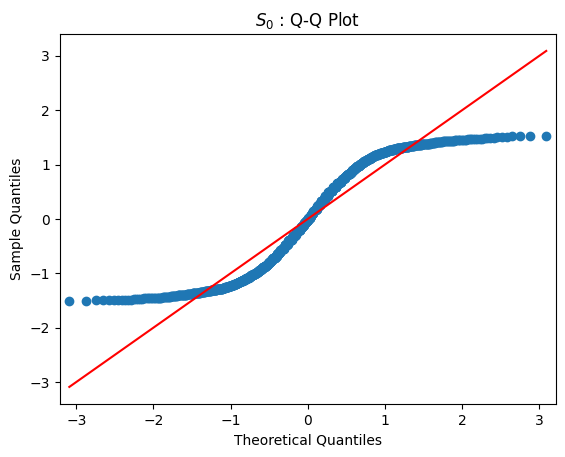

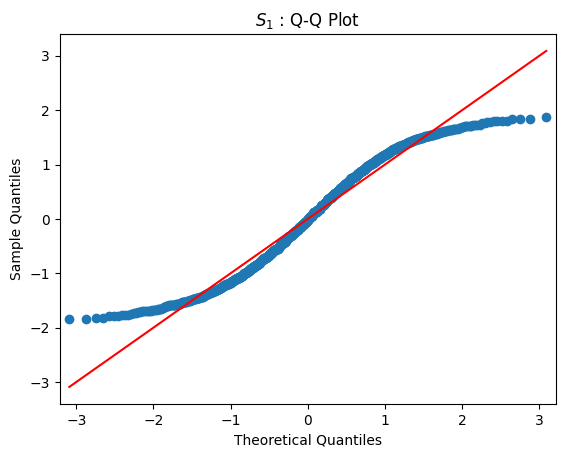

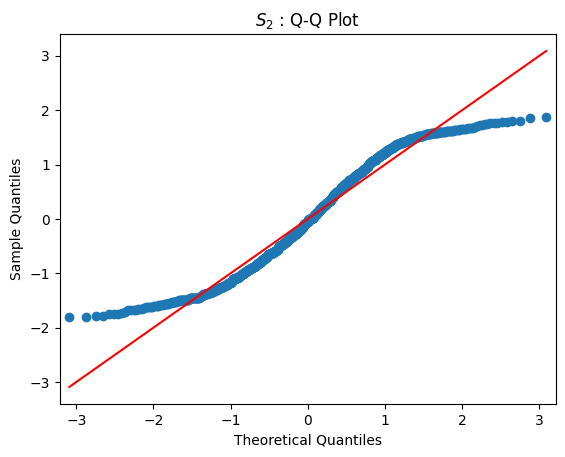

In [6]:
Sw, _, _ = centering_and_whitening(S)
import statsmodels.api as sm
# Create a Q-Q plot
for i in range(n_sources):
    sm.qqplot(Sw[i], line='s')
    plt.title(f'$S_{i}$ : Q-Q Plot')
    plt.show()


## ICA

In [7]:
# Center & whiten signals
import jax
OP_key = jax.random.PRNGKey(106)
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W = fast_ica(OP_key, X)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

Took 0.42727065086364746 s to run


In [8]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W, mcc = fast_ica2(X, true_sources=S)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

component 0
iteration : 0 : distance 0.07847732305526733
----- MCC = 0.5488585929075877
iteration : 1 : distance 0.0027273893356323242
----- MCC = 0.54268150528272
iteration : 2 : distance 0.001961946487426758
----- MCC = 0.5333652794361115
iteration : 3 : distance 0.002757430076599121
----- MCC = 0.521459291378657
iteration : 4 : distance 0.005754053592681885
----- MCC = 0.502101888259252
iteration : 5 : distance 0.017344176769256592
----- MCC = 0.7326955795288086
iteration : 6 : distance 0.05447959899902344
----- MCC = 0.7968344291051229
iteration : 7 : distance 0.053377389907836914
----- MCC = 0.8373167316118876
iteration : 8 : distance 0.0037363767623901367
----- MCC = 0.8431093891461691
iteration : 9 : distance 2.5928020477294922e-05
----- MCC = 0.8434200882911682
iteration : 10 : distance 5.364418029785156e-07
----- MCC = 0.8434504469235738
iteration : 11 : distance 5.960464477539063e-08
----- MCC = 0.8434470494588217
iteration : 12 : distance 0.0
----- MCC = 0.8434486190478007
c

In [9]:
import jax.numpy as jnp

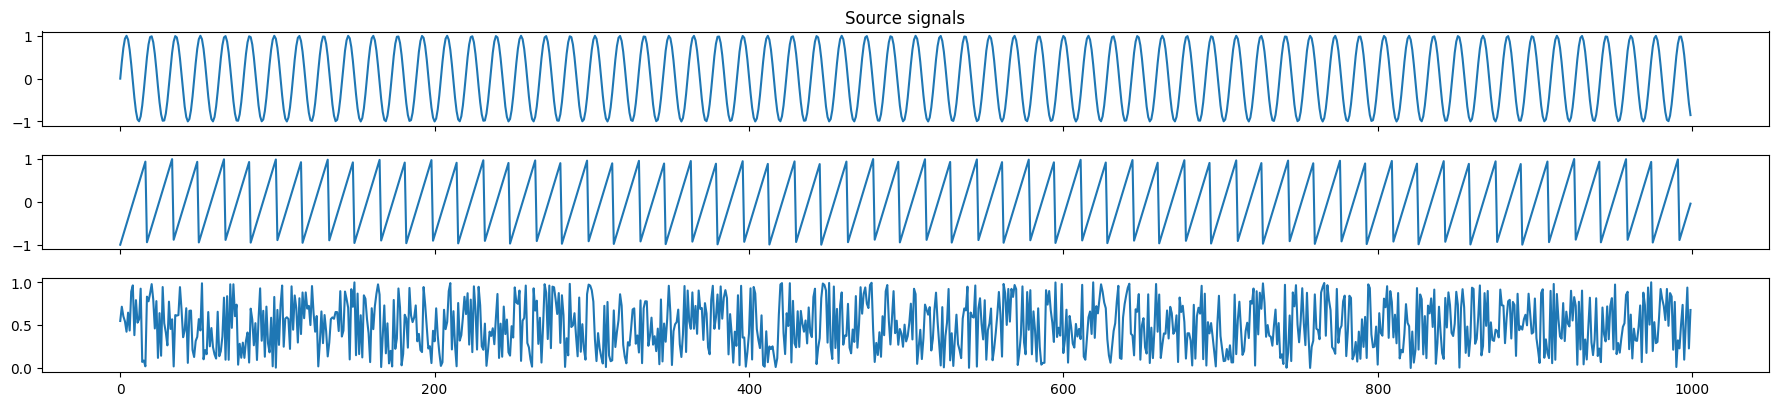

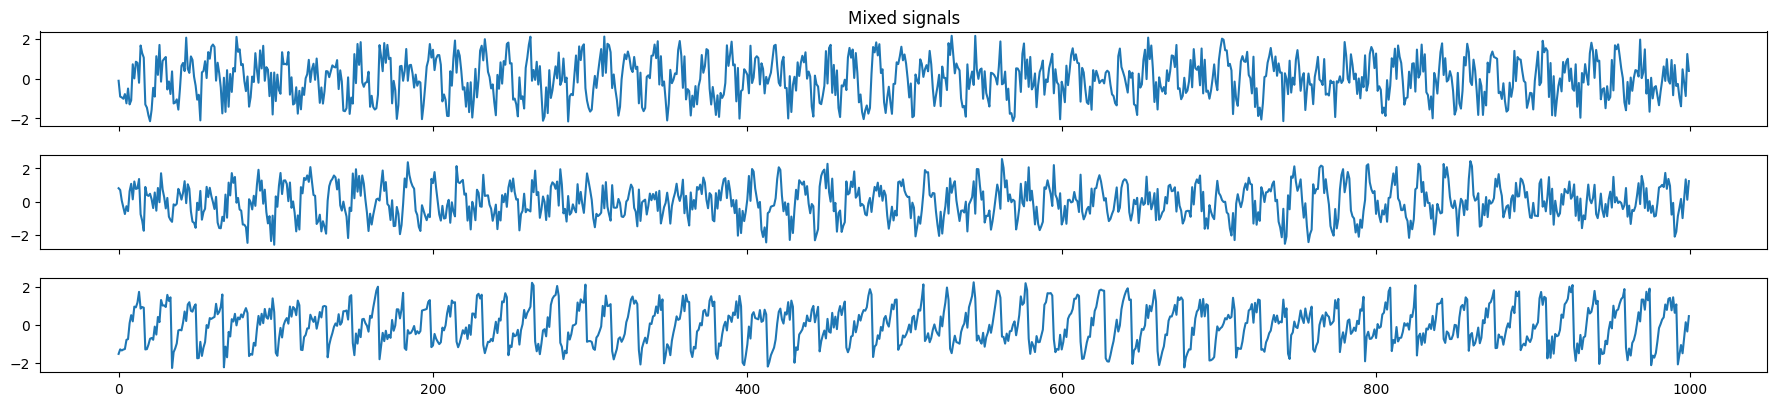

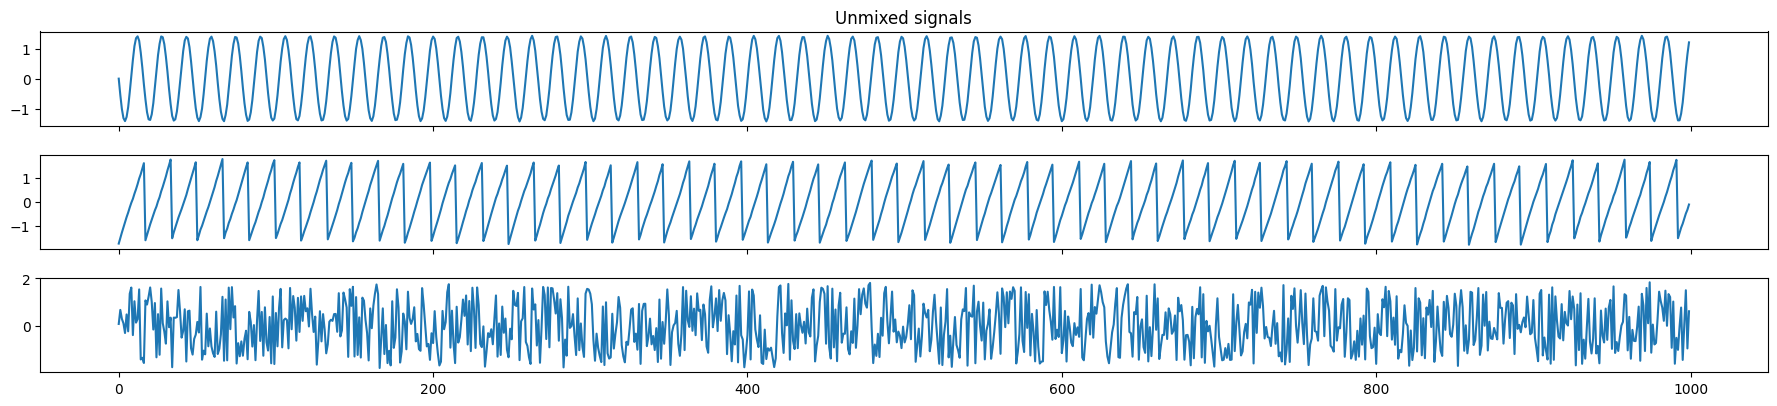

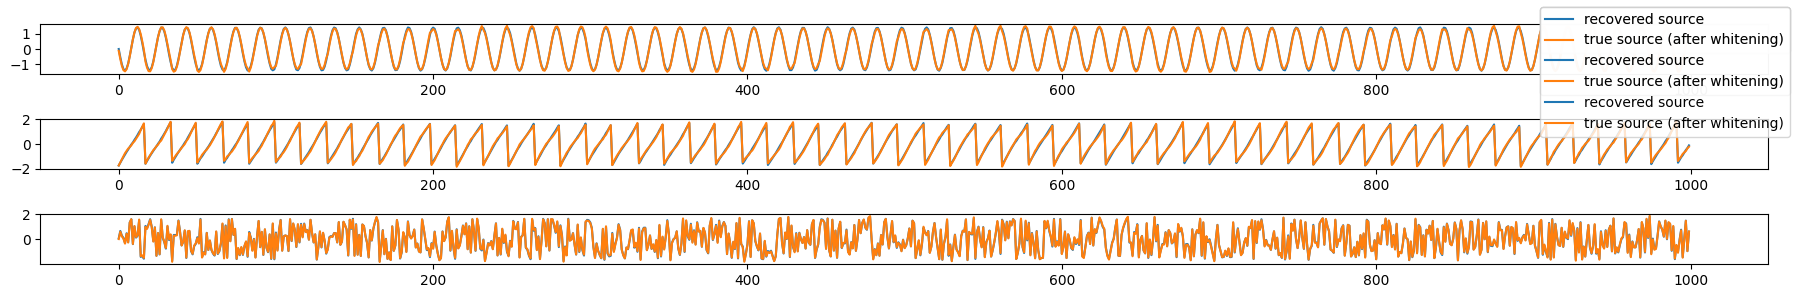

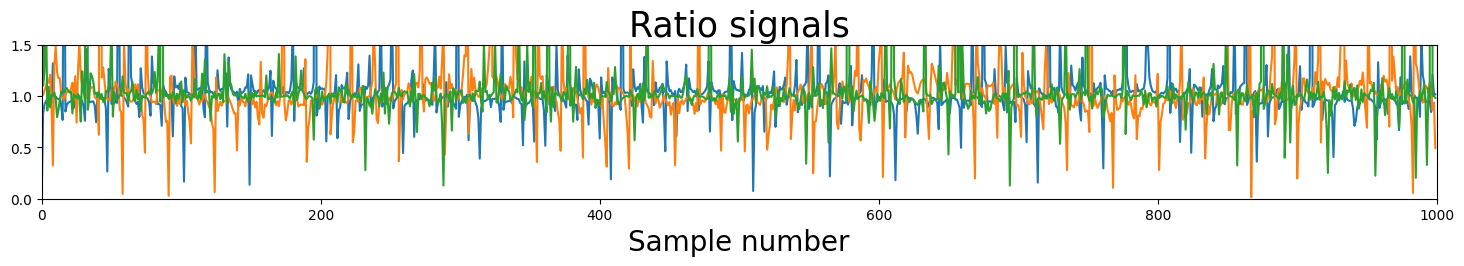

In [39]:
# Plot input signals (not mixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Source signals')
for i in range(n_signals):
    axes[i].plot(S[i])

# Plot mixed signals 
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Mixed signals')
for i in range(n_signals):
    axes[i].plot(X[i])


# Plot recovered signals (unmixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Unmixed signals')
for i in range(n_signals):
    axes[i].plot(unMixed[i])

Sw, _, _ = centering_and_whitening(S)
perm = jnp.argmax(jnp.abs(unMixed @ S.T),
                    axis=0)

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3])
fig.tight_layout()
for i in range(n_signals):
    ax[i].plot(unMixed[i].T, label='recovered source')
    ax[i].plot(Sw[perm[i]].T, label='true source (after whitening)')
    fig.legend()
    # ax.set_ylim(-1.5, 1.5)


fig, ax = plt.subplots(1, 1, figsize=[18, 2])
for i in range(n_sources):
    ax.plot(np.abs(unMixed[i].T / Sw[perm[i]].T), '-', label='Recovered signals')
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Ratio signals', fontsize=25)
ax.set_xlim(0, S.shape[1])
ax.set_ylim(0, 1.5)
plt.show()

Although estimated sources and true sources seem to match perfectly, we can see that the "ratio" signal is not completely flat. This is due to the zero values present in the signals.

# Figures in Latex

In [11]:
%pwd

'c:\\Users\\TRETEC\\Documents\\MVA\\S1\\[IPGM] Introduction to probabilistic graphical models\\Projet\\independent_component_analysis'

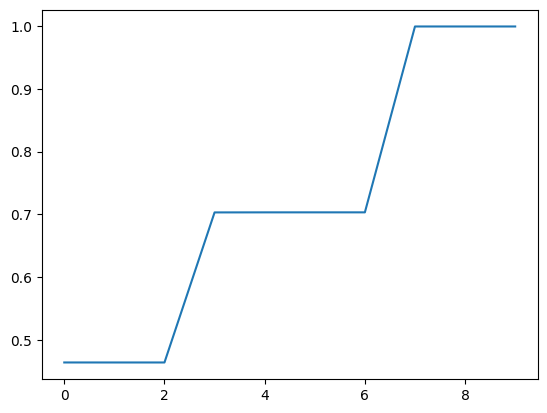

In [17]:
plt.plot(mcc)

In [15]:
# LaTeX code for the subplot
subplot_code_ = r'''
\nextgroupplot[
        title=Evolution of MCC during FastICA algorithm iterations on synthetic data,
        xlabel={iterations},
        ylabel={MCC Score},
        xmin=0, xmax=%d,
        ymin=%f, ymax=%f
        ]
\addplot[
    color=blue,
    mark=*,
    style={very thick},
] coordinates {
    %s
};
''' % (len(mcc)-1, min(mcc)-0.1, 1, ' '.join(f'({i},{score:.2f})' for i, score in enumerate(mcc)))

# Save the LaTeX code to a file
file_path = 'report/figures_latex/mcc_toy_sources_fastica.tex'  # Path to save the .tex file
with open(file_path, 'w') as file:
    file.write(subplot_code_.strip())
